### Operational Planning Marginal Requirements (OPMR)
The Operational Planning Marginal Requirements (OPMR) represent the surplus generation beyond forecasted demand needed to meet reserve requirements. This notebook focuses on analyzing extreme variations in generation availability margins—the difference between generation availability and peak demand forecasts—as well as high-frequency response requirements and negative reserves.

The data is sourced from the NESO API and processed for analysis.

**Notebook structure**
1. **Data Collection**
    - Retrieving OPMR-related data from NESO.
2. **Data Processing**
    -Cleaning, transforming, and preparing the dataset for analysis.

3. **Generation availability margin**

    - **Negative margins**: Investigating periods where generation is insufficient to meet peak demand, assessing the link between generation-demand imbalances, low-frequency services, and positive reserve pricing.

    - **Extreme high margins (> 20 GW):** Examining periods of surplus generation to determine how excess supply is managed (e.g., storage, curtailment, or export via interconnectors).

4. **High-frequency response  and negative reserves**
    - Analyzing the correlation between high-frequency response demand, negative reserves, and minimum demand forecasts.
    
5. **Conclusion**
    - Identifying key periods for further in-depth analysis.
    - Extracting insights for forecasting frequency response and reserve pricing.


In [17]:
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
import urllib3

In [2]:
def neso_api_to_df(api: str):
    '''Fetches data from the NESO API and converts it into a Pandas DataFrame'''
    try:
        http = urllib3.PoolManager()
        request = http.request('GET', api)
        json_response = request.json() # NESO api returns data in JSON format
        listed_data = json_response['result']['records']
        df = pd.DataFrame(listed_data)
        return df
    except Exception as e:
        print(f"API request error: {e}")
        return pd.DataFrame()
    
def get_short_term_data(df: pd.DataFrame, start_date: str, days: int):
    '''Extracts dataframe from the start date for number of days'''
    start_date = pd.to_datetime(start_date)
    end_date = start_date + timedelta(days = days)
    short_term_data = df[(df.index >= start_date)
                         &(df.index < end_date)].copy()
    return short_term_data


 #### Section I: Data Collection 
 Data is sourced from [NESO: OPMR](https://www.neso.energy/data-portal/daily-opmr/daily_operational_planning_margin_requirement), which is updated daily and provides a  2-14 days ahead forecast for OPMR.  Additionally,  historical data is available from March 2021 onward.
 
 The dataset includes key metrics such as: peak  and minimum demand forecasts, generator availability, interconnectors - import, export, and reserve requirements, generation availability margin, national surplus, opmr, and high-frequency requirements. 

In [3]:
marginal_req_api = 'https://api.neso.energy/api/3/action/datastore_search?resource_id=0eede912-8820-4c66-a58a-f7436d36b95f&limit=200000'
# Fetching data from NESO API for operational margin
opmr_df = neso_api_to_df(marginal_req_api)

#### Section II: Data Processing

Data processing involves cleaning, transforming, and preparing the dataset for analysis. The key steps include:

- **Standardizing Column Names:** Ensuring consistency and clarity for further processing.

- **Unit Conversion:** Converting all relevant columns (e.g., peak demand, generator availability, interconnector imports/exports, frequency response, reserves, constraints, and national surplus) from MW to GW for better readability.

- **Selecting Forecast Data:** Since forecasts become more accurate closer to delivery, only 2-day-ahead forecasts are used for analysis. Longer-term forecasts may be useful for asset allocation optimization.

- **Handling Outliers:** Removing records where peak demand or minimum demand forecasts are zero, as these indicate potential data errors.

- **Indexing by Date:** Setting the date column as the DataFrame index for efficient time-series analysis.

In [4]:
# Standardizing column names
original_cols = opmr_df.columns
modified_cols = [col.lstrip('_').lower().replace(' ', '_').replace('/', '') for col in original_cols]
opmr_df.columns = modified_cols

# Unit conversion from MW to GW
mw_to_gw_columns = ['peak_demand_forecast', 'generator_availability', 'maximum_ic_import', 'maximum_ic_export',
                     'generation_availability_margin', 'operating_reserve_provided_by_ics',
                     'opmr_total', 'constrained_plant', 'national_surplus',
                     'minimum_demand_forecast', 'high_freq_response_requirement', 'negative_reserve']                     
opmr_df[mw_to_gw_columns] = opmr_df[mw_to_gw_columns]/1000

# convering data and publish date columns from object to date types
opmr_df.publish_date = pd.to_datetime(opmr_df.publish_date)
opmr_df.date = pd.to_datetime(opmr_df.date)
opmr_df.loc[:, 'forecasting_days_diff' ] = opmr_df['date']-opmr_df['publish_date']

# difference in peak and minimum demands
opmr_df['demand_difference'] = opmr_df['peak_demand_forecast'] - opmr_df['minimum_demand_forecast']

In [5]:
#Selecting forecast data with forecasted for the next 2 days
df = opmr_df[opmr_df.forecasting_days_diff == '2 days'].copy()
# Excluding outliers
df = df[~(df.peak_demand_forecast == 0)] 
df = df[~(df.minimum_demand_forecast == 0)] 
# Setting up date as index 
df.set_index('date', inplace = True, drop = False)
df.head()

,id,publish_date,date,peak_demand_forecast,generator_availability,maximum_ic_import,maximum_ic_export,generation_availability_margin,operating_reserve_provided_by_ics,opmr_total,constrained_plant,national_surplus,minimum_demand_forecast,high_freq_response_requirement,negative_reserve,forecasting_days_diff,demand_difference
date,,,,,,,,,,,,,,,,,
2021-03-14,1,2021-03-12,2021-03-14,37.592,54.770,5.646,5.646,17.178,0.0,5.068,0.253,12.110,20.090,0.858,2.860,2 days,17.502
2021-03-15,14,2021-03-13,2021-03-15,41.319,49.305,5.560,5.560,7.986,0.0,3.994,0.000,3.992,21.972,0.678,2.532,2 days,19.347
2021-03-16,27,2021-03-14,2021-03-16,39.159,57.627,5.560,5.560,18.468,0.0,5.413,0.530,13.055,22.588,0.627,2.440,2 days,16.571
2021-03-17,40,2021-03-15,2021-03-17,40.344,49.719,5.560,5.560,9.375,0.0,4.289,0.000,5.086,22.774,0.612,2.413,2 days,17.570
2021-03-18,53,2021-03-16,2021-03-18,38.593,52.960,5.646,5.646,14.367,0.0,4.671,0.000,9.696,22.856,0.606,2.402,2 days,15.737


#### Section III: Generation availability margin: extreme values

A **negative generation availability margin** (where demand exceeds generation)  indicates potential grid stress, requiring NESO to secure additional reserves to prevent shortages. 

Conversely, when excess power remains after meeting peak demand and operational margin requirements, it can be **exported via interconnectors** or **curtailed**. Similarly, days with **very low minimum demand forecasts** necessitate increased **frequency response** to maintain grid stability. 

**Exploratory data analysis for winter and summer**

In [ ]:
winter_data = get_short_term_data(df, '2024-12-01', 64)[['generator_availability', 'peak_demand_forecast']]
summer_data = get_short_term_data(df, '2024-04-01', 64)[['generator_availability', 'peak_demand_forecast']]

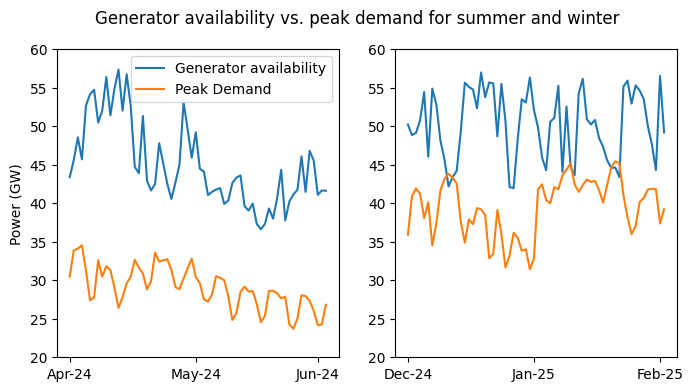

In [64]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax2, ax1 = ax[0], ax[1]

ax1.plot(winter_data, label = ['Generator availability', 'Peak Demand'])
ax1.set_ylim([20, 60]);
# ax1.set_title('Winter 2024/25');
xticks = winter_data.index[0:-1:31]
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
ax1.set_xticks(xticks, );


ax2.plot(summer_data, label = ['Generator availability', 'Peak Demand'])
ax2.set_ylim([20, 60]);
# ax2.set_title('Summer 24');
xticks = summer_data.index[0:-1:30]
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
ax2.set_xticks(xticks, );
ax2.legend(ncols = 1);
ax2.set_ylabel('Power (GW)');
fig.suptitle('Generator availability vs. peak demand for summer and winter');

In [65]:
#Lowest generation availability
min_gen_avail_margin = df.generation_availability_margin.min()
min_gen_avail_date = df.generation_availability_margin.idxmin()
print('The minimum generation availability margin is:', min_gen_avail_margin, 'GW on', min_gen_avail_date.strftime('%Y-%m-%d'))
#Highest generation availability
max_gen_avail_margin = df.generation_availability_margin.max()
max_gen_avail_date = df.generation_availability_margin.idxmax()
print('The maximum generation availability margin is:', max_gen_avail_margin, 'GW on', max_gen_avail_date.strftime('%Y-%m-%d'))

The minimum generation availability margin is: -1.795 GW on 2025-01-22
The maximum generation availability margin is: 30.944 GW on 2024-04-13


In [66]:
#Negative generation margin availability
neg_avail_index = sorted(df[df.generation_availability_margin < 0].index.tolist(), reverse = True)
neg_avail_dates = [date.strftime('%Y-%m-%d') for date in neg_avail_index]
print('Generators availabilty is below than peak demand on: \n', neg_avail_dates)

# Days of large generation availability margin
large_gen_avail_index = sorted(df.generation_availability_margin.nlargest(10).index.tolist(), reverse = True)
large_gen_avail_dates = [date.strftime('%Y-%m-%d') for date in large_gen_avail_index]
# large_gen_avail_dates = df.loc[large_gen_avail_index, 'date'].unique().tolist()
print('Days of large generation margin: \n', large_gen_avail_dates)

Generators availabilty is below than peak demand on: 
 ['2025-01-22', '2025-01-21', '2025-01-20', '2025-01-10', '2024-12-11', '2022-12-12', '2022-12-11', '2022-11-29', '2022-01-24']
Days of large generation margin: 
 ['2024-04-15', '2024-04-13', '2024-04-07', '2024-04-06', '2024-03-23', '2023-12-30', '2023-12-24', '2023-04-09', '2022-01-01', '2021-04-04']


#### Section IV. High frequency response and Negative reserves

In this section, plots are illustarted for two cases:
1. Correlation of high-frequency response and negative reserves to the minimum demand forecast
2. A week data including the day of maximum requirements of both negative reserve and high-frequency response

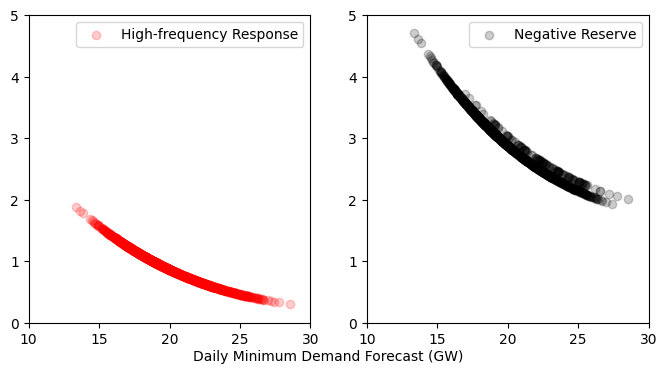

In [67]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax1, ax2 = ax[0], ax[1]
y_lims = [0, 5]
x_lims = [10, 30]
ax1.scatter(x = 'minimum_demand_forecast', y = 'high_freq_response_requirement', data = df, alpha = 0.2, color = 'red', label = 'High-frequency Response');
# ax1.set_ylabel('High Frequency Response (GW)')
ax1.set_ylim(y_lims)
ax1.set_xlim(x_lims)
ax1.legend()
ax2.scatter(x = 'minimum_demand_forecast', y = 'negative_reserve',  data = df, alpha = 0.2, color = 'black', label = 'Negative Reserve');
ax2.set_ylim(y_lims)
ax2.set_xlim(x_lims)
ax2.legend()
# ax2.set_ylabel('Negative Reserve (GW)')
fig.supxlabel('Daily Minimum Demand Forecast (GW)', fontsize = 10);

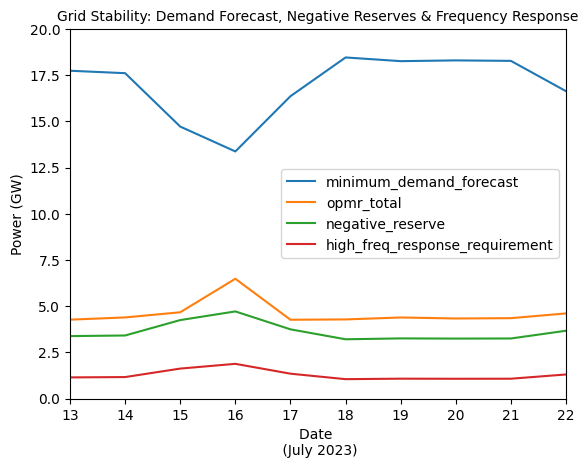

In [79]:
short_term_data = get_short_term_data(df, '2023-07-13',10)[[ 'minimum_demand_forecast','opmr_total', 'negative_reserve', 'high_freq_response_requirement',]]
short_term_data.plot(); #
plt.ylabel('Power (GW)');
plt.xlabel('Date \n (July 2023)');
plt.legend(ncol =1);
plt.ylim([0, 20]);
plt.title('Grid Stability: Demand Forecast, Negative Reserves & Frequency Response', fontsize = 10);
xticks, xlabels,= plt.xticks();
step = 1
xticks_new = np.arange(xticks[0], xticks[1] + step, step)
start_day, end_day = short_term_data.index.min().day, short_term_data.index.max().day
xlables_new = np.arange(start_day, end_day+step, step)
plt.xticks(xticks_new, xlables_new);

In [69]:
# Maximum requirement of high-frequency response
max_high_freq_margin = df.high_freq_response_requirement.max()
max_high_freq_margin_date = df.high_freq_response_requirement.idxmax()
print('The maximum high-frequency requirement is:', max_high_freq_margin, 'GW on', max_high_freq_margin_date.strftime('%Y-%m-%d'))
# Maximum requirement of negative reserve
max_negative_reserve = df.negative_reserve.max()
max_negative_reserve_date = df.negative_reserve.idxmax()
print('The maximum negative reserve requirement is:', max_negative_reserve, 'GW on', max_negative_reserve_date.strftime('%Y-%m-%d'))

The maximum high-frequency requirement is: 1.877 GW on 2023-07-16
The maximum negative reserve requirement is: 4.713 GW on 2023-07-16


In [75]:
df[df.index>'2023-11-01'].high_freq_response_requirement.idxmax(), df[df.index>'2023-11-01'].negative_reserve.idxmax()

(Timestamp('2023-12-24 00:00:00'), Timestamp('2023-12-24 00:00:00'))

#### Section 5: Conclusion
<p style="margin-bottom: 5px;"></p>

##### 5.1: Further Analytics Tasks
Building on the findings above, further exploration of frequency response pricing, reserve services, and curtailments during key periods is recommended.

**Negative generation availability margin periods**
1. December 11–12, 2025
2. January 10, 2025
3. January 20–22, 2025

During **negative generation availability, higher prices for positive response services and low-frequency services** are expected.  Additionally, power imports via interconnectors may increase. On **January 22, 2025**, the **maximum negative generation availability reached 1.9 GW**, making it an important case study for understanding how the supply-demand balance was maintained. Possible solutions may have included: 

- Low-frequency responses
- Positive reserves
- Increased imports via interconnectors
- Demand-side response measures

**Periods of Extreme High Generation Availability Margin**
1. April 6–7, 2024
2. April 12–15, 2024

During these periods, the **generation availability margin exceeded 25 GW**. Given the **UK's limited storage capacity and export constraints**, generators were likely **curtailed**. A detailed analysis of curtailments on these days would provide further insights into how surplus generation was managed.

**High-frequency response and negative reserves**

Both high-frequency response requirements and negative reserves show a **strong correlation with the minimum demand forecast.** As the **minimum demand forecast decreases**, the imbalance between generation and demand increases, leading to **higher negative reserve and high-frequency response requirements.**

#### 5.2: Key findings for price prediction
1. **Minimum demand forecast** is a crucial parameter for predicting **negative reserves and high-frequency response pricing**.
2. **Generation availability margin** plays a key role in forecasting **low-frequency service and positive reserve pricing.**